<a href="https://colab.research.google.com/github/ossnat/VSD_foundation_model_evaluation/blob/main/LoopOverPretrainedModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/

/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate


In [3]:
%pwd

'/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate'

In [4]:
# import os
# if not os.path.exists("VSD_foundation_model_evaluation"):
#     !git clone https://github.com/ossnat/VSD_foundation_model_evaluation.git


In [5]:
%cd VSD_foundation_model_evaluation/

/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation


In [6]:
!git pull

remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 7), reused 10 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (14/14), 4.37 KiB | 3.00 KiB/s, done.
From https://github.com/ossnat/VSD_foundation_model_evaluation
   8da4a84..1555362  main       -> origin/main
Updating 8da4a84..1555362
Fast-forward
 models/backbones.py        |  76 ++++++++++++------
 models/model_evaluation.py | 187 +++++++++++++++++++++++++++++++++++++++++++++
 2 files changed, 239 insertions(+), 24 deletions(-)
 create mode 100644 models/model_evaluation.py


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation')
sys.path.append('/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation/src')
sys.path.append('/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation/models')
sys.path.append('/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation/config')
sys.path.append('/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation/data_utils')

In [8]:
import yaml
import os

# Construct the full path to the config file
config_path = os.path.join("config", "model_config.yaml")

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# Ensure num_classes is set to 2 for binary classification
config["model"]["num_classes"] = 2
print("Loaded config with num_classes set to 2:")
print(config)

Loaded config with num_classes set to 2:
{'training': {'epochs': 20, 'batch_size': 8, 'learning_rate': 0.001, 'device': 'auto'}, 'data': {'dataset_path': './data/frodo_early', 'num_frames': 5, 'num_workers': 4, 'start_frame': 28, 'end_frame': 58}, 'model': {'backbone': 'dino', 'temporal_pooling': 'mean', 'embedding_dim': 768, 'num_classes': 2}}


#### Load Data

In [9]:
import data_utils.prepare_data
import src

In [10]:
from data_utils.prepare_data import prepare_vsd_data, preprocess_vsd_clip, get_train_val_test_loaders
from src.dataset import VSDClipsDataset, split_trials
from torch.utils.data import DataLoader

In [12]:
import numpy as np
vertical_path = "./data/frodo_early_0/vertical_data.npy"
horizontal_path = "./data/frodo_early_0//horizontal_data.npy"

vertical_data = prepare_vsd_data(vertical_path)     # (117, 80, 1, 100, 100)
horizontal_data = prepare_vsd_data(horizontal_path)

# Build labels: 0 for vertical, 1 for horizontal
vertical_labels = np.zeros(len(vertical_data), dtype=int)
horizontal_labels = np.ones(len(horizontal_data), dtype=int)

# Concatenate
data = np.concatenate([vertical_data, horizontal_data], axis=0)
original_labels = np.concatenate([vertical_labels, horizontal_labels], axis=0)

labels = original_labels.copy()
print("Final data shape:", data.shape)   # (N, 80, 1, 100, 100)
print("Labels shape:", labels.shape)


Final data shape: (62, 80, 1, 100, 100)
Labels shape: (62,)


In [13]:
# Split
train_idx, val_idx, test_idx = split_trials(data, labels)

# Build datasets
train_dataset = VSDClipsDataset(data[train_idx], labels[train_idx], config, clip_len=5)
val_dataset   = VSDClipsDataset(data[val_idx], labels[val_idx], config, clip_len=5)
test_dataset  = VSDClipsDataset(data[test_idx], labels[test_idx], config, clip_len=5)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0) #!!! FIX back!!!
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


In [14]:
train_loader, val_loader, test_loader = get_train_val_test_loaders(data, labels, VSDClipsDataset, DataLoader, config,
                               train_idx, val_idx, test_idx)

get_train_val_test_loaders: Shape of data and labels: (62, 80, 1, 100, 100), (62,)
get_train_val_test_loaders: Length of train_idx: 43


In [15]:
# Get one batch from the dataloader
clips, batch_labels = next(iter(train_loader))

print('### clip shape:',clips.shape, type(clips))
print('### batch_labels shape:', batch_labels.shape, type(batch_labels))

### clip shape: torch.Size([8, 5, 3, 224, 224]) <class 'torch.Tensor'>
### batch_labels shape: torch.Size([8]) <class 'torch.Tensor'>


### clips shape: torch.Size([8, 5, 3, 224, 224]) <class 'torch.Tensor'>
### clip shape: torch.Size([5, 3, 224, 224]) <class 'torch.Tensor'>


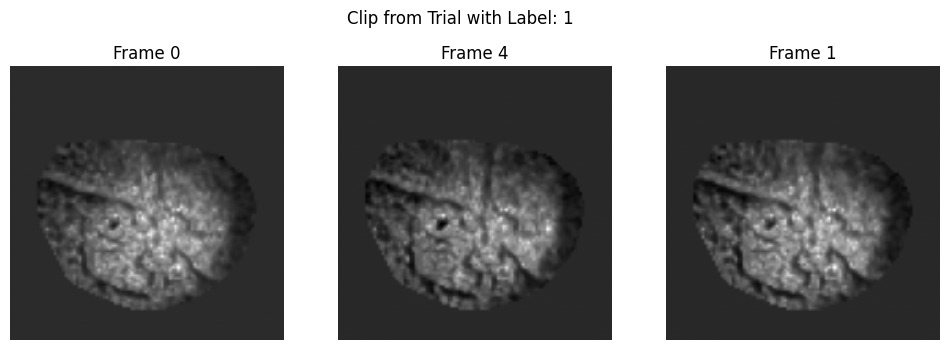

In [16]:
import matplotlib.pyplot as plt
import random

# Get one batch from the dataloader
clips, batch_labels = next(iter(train_loader))
# clips shape: (B, T, C, H, W) -> (8, 5, 1, 100, 100)
print('### clips shape:',clips.shape, type(clips))

# Pick the first clip in the batch
clip = clips[0]  # shape: (T, C, H, W) -> (5, 1, 100, 100)
print('### clip shape:',clip.shape, type(clip))
label = batch_labels[0].item() # Use batch_labels here

# Pick 3 random frame indices
T = clip.shape[0]
frame_indices = random.sample(range(T), 3) # Select 3 random indices

# Plot frames
plt.figure(figsize=(12, 4))
for i, idx in enumerate(frame_indices):
    frame = clip[idx].squeeze().cpu().numpy()  # (H, W) after squeezing C=1
    plt.subplot(1, 3, i+1)
    plt.imshow(frame[1,:,:], cmap="gray")
    plt.title(f"Frame {idx}")
    plt.axis('off')

plt.suptitle(f"Clip from Trial with Label: {label}")
plt.show()

In [17]:
# Labels quick check
from collections import Counter
all_labels_sampled = [] # Use a different variable name to avoid conflict
for _, batch_labels in train_loader: # Use batch_labels here
    all_labels_sampled.extend(batch_labels.numpy().tolist()) # Use batch_labels here
    if len(all_labels_sampled) > 1000: break
print("label counts (sampled):", Counter(all_labels_sampled))

# print first batch labels
clips, batch_labels = next(iter(train_loader)) # Use batch_labels here
print("batch labels:", batch_labels) # Use batch_labels here

label counts (sampled): Counter({1: 518, 0: 490})
batch labels: tensor([0, 0, 0, 0, 1, 1, 0, 0])


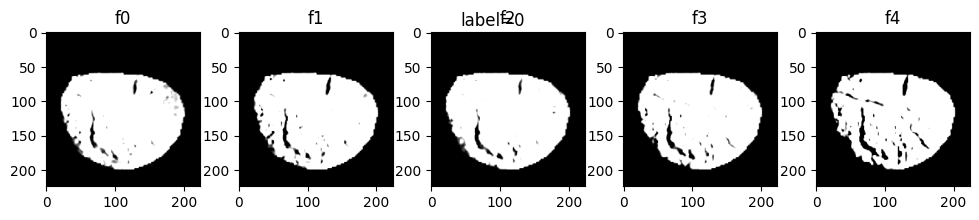

In [18]:
import matplotlib.pyplot as plt
clips, labels = next(iter(train_loader))  # clips: (B,T,C,H,W)
clip = clips[0]   # first clip
label = labels[0].item()
T = clip.shape[0]
plt.figure(figsize=(12,2))
for i in range(min(T,5)):
    im = clip[i].permute(1,2,0).squeeze().cpu().numpy()
    plt.subplot(1,5,i+1); plt.imshow(im, cmap='gray'); plt.title(f"f{i}");
plt.suptitle(f"label={label}")
plt.show()


#### Train model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
BATCH_SIZE = 8
EPOCHS = 5
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
def get_embedding_dim(config):
    backbone_name = config["model"]["backbone"]
    if 'dino' in backbone_name:
        return 768
    elif 'resnet' in backbone_name:
        return 512
    else:
      print(f"Warning: Unknown backbone '{backbone_name}', using default embedding_dim={embedding_dim}")
      return config["model"].get("embedding_dim", 768)


In [22]:
from models.classifier import VideoClassifier
from src.train import train_model

# for debug only -- REMOVE!!!!
config["training"]["epochs"] = 5
config["model"]["embedding_dim"] = get_embedding_dim(config)

In [23]:
# Quick Sanity Test:
clips, labels = next(iter(train_loader))  # [B, T, C, H, W]
B, T, C, H, W = clips.shape
clips_flat = clips.view(B*T, C, H, W)
print("Flattened clips shape:", clips_flat.shape, flush=True)


Flattened clips shape: torch.Size([40, 3, 224, 224])


## Set up directories

### Subtask:
Create directories for saving trained models (`trained_models`) and evaluation results (`test_results`) if they don't exist.


In [24]:
backbones = ['dino2d', 'resnet18']
temporal_pooling_methods = ['mean', 'attention']

In [25]:
import os

# Define directory paths
trained_models_dir = "trained_models"
test_results_dir = "test_results"

# Create directories if they don't exist
os.makedirs(trained_models_dir, exist_ok=True)
os.makedirs(test_results_dir, exist_ok=True)

print(f"Created directory: {trained_models_dir}")
print(f"Created directory: {test_results_dir}")

Created directory: trained_models
Created directory: test_results


### Training and evaluation loop

In [26]:
for backbone_name in backbones:
    for temporal_pooling_method in temporal_pooling_methods:
        print(f"Processing backbone: {backbone_name}, temporal pooling: {temporal_pooling_method}")

Processing backbone: dino2d, temporal pooling: mean
Processing backbone: dino2d, temporal pooling: attention
Processing backbone: resnet18, temporal pooling: mean
Processing backbone: resnet18, temporal pooling: attention


In [27]:
device = config["training"]["device"]
print('#######', device)
if device == "auto":
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device(device)

####### auto


In [29]:
for backbone_name in backbones:
    for temporal_pooling_method in temporal_pooling_methods:
        print(f"\n--- Processing backbone: {backbone_name}, temporal pooling: {temporal_pooling_method} ---")

        # Construct unique filename and model path
        n_epochs = config["training"]["epochs"]
        model_filename = f"{backbone_name}_{temporal_pooling_method}_epochs_{n_epochs}_model.pth"
        model_path = os.path.join(trained_models_dir, model_filename)

        # update config
        config["model"]["backbone"] = backbone_name
        config["model"]["temporal_pooling"] = temporal_pooling_method
        config["model"]["embedding_dim"] = get_embedding_dim(config)
        labels = original_labels.copy()

        # Add print statements for debugging
        print(f"Shape of data before calling get_train_val_test_loaders: {data.shape}")
        print(f"Length of train_idx: {len(train_idx)}")
        # print(f"First 5 elements of train_idx: {train_idx[:5]}")


        train_loader, val_loader, test_loader = get_train_val_test_loaders(data, labels, VSDClipsDataset, DataLoader, config,
                               train_idx, val_idx, test_idx)

        if os.path.exists(model_path):
            print(f"Loading pre-trained model from {model_path}")
            # Need to initialize model structure before loading state_dict
            model = VideoClassifier(
                 backbone_name=config["model"]["backbone"],
                 temporal_pooling=config["model"]["temporal_pooling"],
                 embedding_dim=config["model"]["embedding_dim"],
                 num_classes=config["model"]["num_classes"],
             ).to(device) # Assuming 'device' is accessible
            model.load_state_dict(torch.load(model_path, map_location=device))
            # Since we loaded, history is not available from training
            history = None
            trained_model = model # Set trained_model to the loaded model
        else:
            # Need to define or access 'device' here.
            # Since train_model returns device, we should call train_model first
            # or ensure device is determined before the loop.
            # Let's assume device is determined before the loop.
            print(f"Training new model for backbone: {backbone_name}, temporal pooling: {temporal_pooling_method}")
            history, trained_model, device = train_model(config, train_loader, val_loader)

            torch.save(trained_model.state_dict(), model_path)
            print(f"Model saved to {model_path}")



--- Processing backbone: dino2d, temporal pooling: mean ---
Shape of data before calling get_train_val_test_loaders: (62, 80, 1, 100, 100)
Length of train_idx: 43
get_train_val_test_loaders: Shape of data and labels: (62, 80, 1, 100, 100), (62,)
get_train_val_test_loaders: Length of train_idx: 43
Training new model for backbone: dino2d, temporal pooling: mean
####### auto
--- build_backbone -- dino2d
--- build_backbone model name:  openai/clip-vit-base-patch32


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:03<08:41,  3.75s/it]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:04<03:58,  1.73s/it]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:04<02:28,  1.09s/it]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:04<01:46,  1.27it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:05<01:23,  1.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:05<01:09,  1.94it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:05<01:00,  2.21it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:05<00:54,  2.43it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:06<00:50,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:06<00:47,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:06<00:45,  2.84it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:07<00:43,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:07<00:42,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:07<00:41,  3.02it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:08<00:41,  3.04it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:08<00:40,  3.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:08<00:40,  3.07it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:09<00:39,  3.07it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:09<00:39,  3.07it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:09<00:38,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:10<00:38,  3.11it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:10<00:37,  3.11it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:10<00:37,  3.11it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:11<00:37,  3.11it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:11<00:36,  3.11it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:11<00:36,  3.10it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:12<00:36,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:12<00:36,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:12<00:35,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:13<00:35,  3.07it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:13<00:35,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:13<00:35,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:14<00:34,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:14<00:34,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:14<00:34,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:15<00:33,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:15<00:33,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:15<00:33,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:16<00:32,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:16<00:32,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:16<00:32,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:16<00:31,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:17<00:31,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:17<00:31,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:17<00:30,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:18<00:30,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:18<00:30,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:18<00:29,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:19<00:29,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:19<00:29,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:19<00:28,  3.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:20<00:28,  3.08it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:20<00:28,  3.06it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:20<00:28,  3.06it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:21<00:27,  3.06it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:21<00:27,  3.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:21<00:27,  3.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:22<00:26,  3.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:22<00:26,  3.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:22<00:26,  3.04it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:23<00:25,  3.04it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:23<00:25,  3.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:23<00:25,  3.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:24<00:24,  3.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:24<00:24,  3.04it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:24<00:24,  3.04it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:25<00:24,  3.03it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:25<00:23,  3.02it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:25<00:23,  3.02it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:26<00:23,  3.02it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:26<00:22,  3.03it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:26<00:22,  3.03it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:27<00:22,  3.02it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:27<00:21,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:27<00:21,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:28<00:21,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:28<00:20,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:28<00:20,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:29<00:20,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:29<00:19,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:29<00:19,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:30<00:19,  2.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:30<00:19,  2.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:30<00:18,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:31<00:18,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:31<00:18,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:31<00:17,  2.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:32<00:17,  2.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:32<00:16,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:32<00:16,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:33<00:16,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:33<00:15,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:33<00:15,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:34<00:15,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:34<00:14,  3.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:34<00:14,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:35<00:14,  2.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:35<00:13,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:35<00:13,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:36<00:13,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:36<00:13,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:36<00:12,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:37<00:12,  3.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:37<00:12,  2.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:37<00:11,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:38<00:11,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:38<00:11,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:38<00:10,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:39<00:10,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:39<00:10,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:39<00:09,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:40<00:09,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:40<00:09,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:40<00:08,  2.96it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:41<00:08,  2.96it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:41<00:08,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:41<00:07,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:42<00:07,  2.95it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:42<00:07,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:42<00:06,  2.96it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:43<00:06,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:43<00:06,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:43<00:05,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:44<00:05,  2.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:44<00:05,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:44<00:04,  2.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:45<00:04,  2.96it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:45<00:04,  2.96it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:45<00:03,  2.96it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:46<00:03,  2.96it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:46<00:03,  2.96it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:46<00:02,  2.95it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:47<00:02,  2.95it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:47<00:02,  2.95it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:47<00:01,  2.94it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:48<00:01,  2.94it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:48<00:01,  2.94it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:48<00:00,  2.95it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:49<00:00,  2.95it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.67it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  7.69it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:00<00:02,  8.20it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  8.20it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  8.43it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:01,  8.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:01<00:01,  8.44it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  8.36it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  8.34it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  8.40it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:02<00:00,  8.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  8.51it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  8.52it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]


CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])
Epoch 1: train_acc=0.511, val_acc=0.457


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:05,  2.14it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<00:53,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:51,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:49,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:01<00:47,  2.84it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:47,  2.84it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:46,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:02<00:45,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:45,  2.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:03<00:44,  2.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:03<00:44,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:43,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:04<00:43,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:04<00:43,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:42,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:05<00:42,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:05<00:42,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:06<00:41,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:06<00:41,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:06<00:40,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:07<00:40,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:07<00:40,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:07<00:39,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:08<00:39,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:08<00:39,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:09<00:39,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:09<00:38,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:09<00:38,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:10<00:37,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:10<00:37,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:10<00:37,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:11<00:36,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:11<00:36,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:11<00:36,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:12<00:35,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:12<00:35,  2.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:12<00:35,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:13<00:34,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:13<00:34,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:13<00:34,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:14<00:33,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:14<00:33,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:14<00:33,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:15<00:32,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:15<00:32,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:15<00:32,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:16<00:31,  2.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:16<00:31,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:16<00:31,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:17<00:30,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:17<00:30,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:17<00:30,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:18<00:29,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:18<00:29,  2.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:18<00:29,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:19<00:28,  2.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:19<00:28,  2.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:20<00:28,  2.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:20<00:28,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:20<00:27,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:21<00:27,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:21<00:27,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:21<00:26,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:22<00:26,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:22<00:25,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:22<00:25,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:23<00:25,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:23<00:25,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:23<00:24,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:24<00:24,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:24<00:23,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:24<00:23,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:25<00:23,  2.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:25<00:22,  2.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:25<00:22,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:26<00:22,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:26<00:21,  2.89it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:26<00:21,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:27<00:21,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:27<00:20,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:27<00:20,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:28<00:20,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:28<00:19,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:29<00:19,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:29<00:19,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:29<00:18,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:30<00:18,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:30<00:18,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:30<00:17,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:31<00:17,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:31<00:17,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:31<00:16,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:32<00:16,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:32<00:15,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:32<00:15,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:33<00:15,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:33<00:14,  2.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:33<00:14,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:34<00:14,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:34<00:13,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:34<00:13,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:35<00:13,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:35<00:12,  2.85it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:35<00:12,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:36<00:12,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:36<00:11,  2.85it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:37<00:11,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:37<00:11,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:37<00:10,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:38<00:10,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:38<00:10,  2.87it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:38<00:09,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:39<00:09,  2.85it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:39<00:09,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:39<00:08,  2.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:40<00:08,  2.84it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:40<00:08,  2.84it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:40<00:07,  2.85it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:41<00:07,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:41<00:07,  2.82it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:41<00:06,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:42<00:06,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:42<00:06,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:43<00:05,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:43<00:05,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:43<00:04,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:44<00:04,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:44<00:04,  2.82it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:44<00:03,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:45<00:03,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:45<00:03,  2.82it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:45<00:02,  2.81it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:46<00:02,  2.82it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:46<00:02,  2.81it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:46<00:01,  2.82it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:47<00:01,  2.82it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:47<00:01,  2.82it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:47<00:00,  2.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:48<00:00,  2.82it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.45it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  7.39it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:02,  7.80it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  7.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.95it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  8.05it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:01<00:01,  8.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  8.12it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  8.04it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  8.10it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:02<00:00,  8.13it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  8.13it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  8.12it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:03<00:00,  7.91it/s]


CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])
Epoch 2: train_acc=0.647, val_acc=0.718


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:06,  2.09it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<00:55,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:53,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:51,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:01<00:49,  2.72it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:49,  2.70it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:48,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:02<00:47,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:47,  2.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:03<00:46,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:04<00:46,  2.78it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:46,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:04<00:45,  2.78it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:05<00:45,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:45,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:05<00:44,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:06<00:44,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:06<00:44,  2.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:06<00:43,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:07<00:43,  2.77it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:07<00:43,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:08<00:42,  2.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:08<00:42,  2.74it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:08<00:42,  2.74it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:09<00:41,  2.74it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:09<00:41,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:09<00:41,  2.74it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:10<00:40,  2.74it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:10<00:40,  2.74it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:10<00:39,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:11<00:39,  2.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:11<00:39,  2.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:12<00:38,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:12<00:38,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:12<00:38,  2.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:13<00:37,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:13<00:37,  2.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:13<00:36,  2.76it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:14<00:36,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:14<00:36,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:14<00:35,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:15<00:35,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:15<00:35,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:16<00:34,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:16<00:34,  2.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:16<00:34,  2.74it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:17<00:34,  2.72it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:17<00:33,  2.73it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:17<00:33,  2.73it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:18<00:33,  2.73it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:18<00:32,  2.72it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:19<00:32,  2.71it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:19<00:32,  2.71it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:19<00:31,  2.71it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:20<00:31,  2.70it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:20<00:31,  2.70it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:20<00:30,  2.69it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:21<00:30,  2.70it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:21<00:30,  2.69it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:21<00:29,  2.70it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:22<00:29,  2.69it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:22<00:29,  2.69it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:23<00:28,  2.69it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:23<00:28,  2.68it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:23<00:28,  2.67it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:24<00:27,  2.67it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:24<00:27,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:24<00:27,  2.67it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:25<00:26,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:25<00:26,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:26<00:26,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:26<00:25,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:26<00:25,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:27<00:24,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:27<00:24,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:27<00:24,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:28<00:23,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:28<00:23,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:29<00:23,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:29<00:22,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:29<00:22,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:30<00:22,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:30<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:31<00:21,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:31<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:31<00:20,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:32<00:20,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:32<00:20,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:32<00:19,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:33<00:19,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:33<00:18,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:34<00:18,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:34<00:18,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:34<00:17,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:35<00:17,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:35<00:17,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:36<00:16,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:36<00:16,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:36<00:15,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:37<00:15,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:37<00:15,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:38<00:14,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:38<00:14,  2.54it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:38<00:14,  2.54it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:39<00:13,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:39<00:13,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:40<00:13,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:40<00:12,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:40<00:12,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:41<00:11,  2.52it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:41<00:11,  2.52it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:42<00:11,  2.51it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:42<00:10,  2.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:42<00:10,  2.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:43<00:09,  2.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:43<00:09,  2.49it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:44<00:09,  2.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:44<00:08,  2.52it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:44<00:08,  2.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:45<00:07,  2.51it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:45<00:07,  2.49it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:46<00:07,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:46<00:06,  2.49it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:46<00:06,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:47<00:06,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:47<00:05,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:48<00:05,  2.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:48<00:04,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:48<00:04,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:49<00:04,  2.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:49<00:03,  2.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:50<00:03,  2.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:50<00:02,  2.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:50<00:02,  2.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:51<00:02,  2.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:51<00:01,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:52<00:01,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:52<00:00,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:52<00:00,  2.49it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.88it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.07it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  6.82it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:03,  6.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:03,  6.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.17it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  7.25it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:02<00:02,  7.15it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  7.24it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  7.33it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:03<00:01,  7.34it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:03<00:00,  7.27it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  7.31it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  7.35it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:04<00:00,  7.15it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])


Epoch 3: train_acc=0.761, val_acc=0.748


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:09,  1.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<00:59,  2.32it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:58,  2.35it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:55,  2.46it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:02<00:54,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:53,  2.51it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:52,  2.54it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:03<00:52,  2.52it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:51,  2.54it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:04<00:50,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:04<00:50,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:49,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:05<00:49,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:05<00:48,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:48,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:06<00:48,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:06<00:47,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:07<00:47,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:07<00:46,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:07<00:46,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:08<00:45,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:08<00:45,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:09<00:45,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:09<00:44,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:09<00:44,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:10<00:43,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:10<00:43,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:10<00:42,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:11<00:42,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:11<00:42,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:12<00:41,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:12<00:41,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:12<00:40,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:13<00:40,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:13<00:40,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:14<00:39,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:14<00:39,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:14<00:38,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:15<00:38,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:15<00:37,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:15<00:37,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:16<00:37,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:16<00:36,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:17<00:36,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:17<00:35,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:17<00:35,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:18<00:35,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:18<00:34,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:18<00:34,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:19<00:33,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:19<00:33,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:20<00:33,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:20<00:32,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:20<00:32,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:21<00:32,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:21<00:31,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:21<00:31,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:22<00:30,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:22<00:30,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:23<00:30,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:23<00:29,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:23<00:29,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:24<00:29,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:24<00:28,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:24<00:28,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:25<00:27,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:25<00:27,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:26<00:27,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:26<00:26,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:26<00:26,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:27<00:25,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:27<00:25,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:27<00:25,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:28<00:24,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:28<00:24,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:29<00:24,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:29<00:23,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:29<00:23,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:30<00:22,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:30<00:22,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:31<00:22,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:31<00:21,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:31<00:21,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:32<00:21,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:32<00:20,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:32<00:20,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:33<00:20,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:33<00:19,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:34<00:19,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:34<00:18,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:34<00:18,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:35<00:18,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:35<00:17,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:35<00:17,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:36<00:17,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:36<00:16,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:37<00:16,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:37<00:15,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:37<00:15,  2.66it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:38<00:15,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:38<00:14,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:38<00:14,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:39<00:14,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:39<00:13,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:40<00:13,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:40<00:12,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:40<00:12,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:41<00:12,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:41<00:11,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:41<00:11,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:42<00:10,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:42<00:10,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:43<00:10,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:43<00:09,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:43<00:09,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:44<00:09,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:44<00:08,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:45<00:08,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:45<00:08,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:45<00:07,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:46<00:07,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:46<00:06,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:46<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:47<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:47<00:05,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:48<00:05,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:48<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:48<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:49<00:04,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:49<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:49<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:50<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:50<00:02,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:51<00:02,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:51<00:01,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:51<00:01,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:52<00:01,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:52<00:00,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:53<00:00,  2.60it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.28it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  7.04it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:03,  6.92it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  7.29it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  7.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:02<00:02,  7.37it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  7.37it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  7.45it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  7.45it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:03<00:00,  7.46it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  7.42it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  7.46it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:04<00:00,  7.34it/s]


CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])
Epoch 4: train_acc=0.826, val_acc=0.756


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:09,  1.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<00:58,  2.34it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:57,  2.37it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:54,  2.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:02<00:53,  2.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:52,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:51,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:03<00:51,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:51,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:03<00:50,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:04<00:50,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:49,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:05<00:49,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:05<00:48,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:48,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:06<00:47,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:06<00:47,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:07<00:47,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:07<00:47,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:07<00:46,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:08<00:46,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:08<00:45,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:09<00:45,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:09<00:45,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:09<00:44,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:10<00:44,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:10<00:43,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:10<00:43,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:11<00:43,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:11<00:42,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:12<00:42,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:12<00:41,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:12<00:41,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:13<00:41,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:13<00:40,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:14<00:40,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:14<00:40,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:14<00:39,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:15<00:39,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:15<00:38,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:16<00:38,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:16<00:38,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:16<00:37,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:17<00:37,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:17<00:36,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:17<00:36,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:18<00:36,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:18<00:35,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:19<00:35,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:19<00:34,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:19<00:34,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:20<00:34,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:20<00:33,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:21<00:33,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:21<00:32,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:21<00:32,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:22<00:32,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:22<00:31,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:22<00:31,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:23<00:30,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:23<00:30,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:24<00:29,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:24<00:29,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:24<00:29,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:25<00:28,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:25<00:28,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:26<00:28,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:26<00:27,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:26<00:27,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:27<00:26,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:27<00:26,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:27<00:26,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:28<00:25,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:28<00:25,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:29<00:25,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:29<00:24,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:29<00:24,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:30<00:23,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:30<00:23,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:31<00:23,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:31<00:22,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:31<00:22,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:32<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:32<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:32<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:33<00:20,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:33<00:20,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:34<00:19,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:34<00:19,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:34<00:19,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:35<00:18,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:35<00:18,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:36<00:18,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:36<00:17,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:36<00:17,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:37<00:16,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:37<00:16,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:37<00:16,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:38<00:15,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:38<00:15,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:39<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:39<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:39<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:40<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:40<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:41<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:41<00:12,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:41<00:12,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:43<00:10,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:43<00:10,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:44<00:09,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:44<00:09,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:44<00:09,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:45<00:08,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:45<00:08,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:46<00:08,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:46<00:07,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:46<00:07,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:47<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:47<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:47<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:48<00:05,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:48<00:05,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:49<00:04,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:49<00:04,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:49<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:50<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:50<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:51<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:51<00:02,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:51<00:02,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:52<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:52<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:52<00:01,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:53<00:00,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:53<00:00,  2.62it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.90it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.31it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  7.07it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:03,  6.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  7.31it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.45it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  7.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:02<00:02,  7.46it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  7.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  7.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  7.54it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:03<00:00,  7.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  7.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  7.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  97%|█████████▋| 29/30 [00:03<00:00,  7.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])


Valid: 100%|██████████| 30/30 [00:04<00:00,  7.40it/s]


Epoch 5: train_acc=0.870, val_acc=0.714
Model saved to trained_models/dino2d_mean_epochs_5_model.pth

--- Processing backbone: dino2d, temporal pooling: attention ---
Shape of data before calling get_train_val_test_loaders: (62, 80, 1, 100, 100)
Length of train_idx: 43
get_train_val_test_loaders: Shape of data and labels: (62, 80, 1, 100, 100), (62,)
get_train_val_test_loaders: Length of train_idx: 43
Training new model for backbone: dino2d, temporal pooling: attention
####### auto
--- build_backbone -- dino2d
--- build_backbone model name:  openai/clip-vit-base-patch32


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:19,  1.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<01:02,  2.22it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:57,  2.38it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:54,  2.47it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:02<00:52,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:52,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:51,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:03<00:50,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:50,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:03<00:49,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:04<00:49,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:48,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:05<00:48,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:05<00:47,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:47,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:06<00:46,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:06<00:46,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:07<00:46,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:07<00:45,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:07<00:45,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:08<00:45,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:08<00:44,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:08<00:44,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:09<00:44,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:09<00:43,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:10<00:43,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:10<00:43,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:10<00:42,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:11<00:42,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:11<00:41,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:11<00:41,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:12<00:41,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:12<00:40,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:13<00:40,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:13<00:39,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:13<00:39,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:14<00:39,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:14<00:38,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:15<00:38,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:15<00:38,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:15<00:37,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:16<00:37,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:16<00:37,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:16<00:36,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:17<00:36,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:17<00:35,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:18<00:35,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:18<00:35,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:18<00:34,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:19<00:34,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:19<00:34,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:19<00:33,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:20<00:33,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:20<00:32,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:21<00:32,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:21<00:32,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:21<00:31,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:22<00:31,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:22<00:31,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:23<00:30,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:23<00:30,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:23<00:29,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:24<00:29,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:24<00:29,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:24<00:28,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:25<00:28,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:25<00:28,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:26<00:27,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:26<00:27,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:26<00:26,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:27<00:26,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:27<00:26,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:28<00:25,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:28<00:25,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:28<00:24,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:29<00:24,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:29<00:24,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:29<00:23,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:30<00:23,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:30<00:23,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:31<00:22,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:31<00:22,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:31<00:21,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:32<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:32<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:33<00:20,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:33<00:20,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:33<00:19,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:34<00:19,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:34<00:19,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:34<00:18,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:35<00:18,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:35<00:18,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:36<00:17,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:36<00:17,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:36<00:16,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:37<00:16,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:37<00:16,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:38<00:15,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:38<00:15,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:38<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:39<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:39<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:39<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:40<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:40<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:41<00:12,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:41<00:12,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:41<00:11,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:42<00:11,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:42<00:10,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:43<00:10,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:43<00:09,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:44<00:09,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:44<00:09,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:44<00:08,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:45<00:08,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:45<00:08,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:46<00:07,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:46<00:07,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:46<00:06,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:47<00:06,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:47<00:06,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:47<00:05,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:48<00:05,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:48<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:49<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:49<00:04,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:49<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:50<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:50<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:51<00:02,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:51<00:02,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:51<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:52<00:01,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:52<00:01,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:52<00:00,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:53<00:00,  2.63it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.83it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.26it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  7.16it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:03,  6.98it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  7.39it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.51it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  7.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:02<00:01,  7.52it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  7.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  7.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  7.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:03<00:00,  7.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  7.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  7.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:04<00:00,  7.45it/s]


CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])
Epoch 1: train_acc=0.492, val_acc=0.556


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:09,  2.00it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<00:58,  2.37it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:56,  2.42it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:53,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:02<00:52,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:52,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:50,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:03<00:50,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:50,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:03<00:49,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:04<00:49,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:48,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:05<00:48,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:05<00:48,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:47,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:06<00:47,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:06<00:46,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:06<00:46,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:07<00:45,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:07<00:45,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:08<00:45,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:08<00:44,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:08<00:44,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:09<00:43,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:09<00:43,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:09<00:43,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:10<00:42,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:10<00:42,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:11<00:42,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:11<00:41,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:11<00:41,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:12<00:41,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:12<00:40,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:13<00:40,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:13<00:39,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:13<00:39,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:14<00:39,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:14<00:38,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:14<00:38,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:15<00:37,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:15<00:37,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:16<00:37,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:16<00:36,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:16<00:36,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:17<00:36,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:17<00:35,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:17<00:35,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:18<00:34,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:18<00:34,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:19<00:33,  2.65it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:19<00:33,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:19<00:33,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:20<00:32,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:20<00:32,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:21<00:32,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:21<00:31,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:21<00:31,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:22<00:31,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:22<00:30,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:22<00:30,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:23<00:29,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:23<00:29,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:24<00:29,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:24<00:28,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:24<00:28,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:25<00:28,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:25<00:27,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:25<00:27,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:26<00:27,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:26<00:26,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:27<00:26,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:27<00:25,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:27<00:25,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:28<00:25,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:28<00:24,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:28<00:24,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:29<00:24,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:29<00:23,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:30<00:23,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:30<00:22,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:30<00:22,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:31<00:22,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:31<00:21,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:32<00:21,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:32<00:20,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:32<00:20,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:33<00:20,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:33<00:19,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:33<00:19,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:34<00:18,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:34<00:18,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:35<00:18,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:35<00:17,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:35<00:17,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:36<00:17,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:36<00:16,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:36<00:16,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:37<00:15,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:37<00:15,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:38<00:15,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:38<00:14,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:38<00:14,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:39<00:14,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:39<00:13,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:40<00:13,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:40<00:12,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:40<00:12,  2.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:41<00:12,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:41<00:11,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:41<00:11,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:42<00:11,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:42<00:10,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:43<00:10,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:43<00:09,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:43<00:09,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:44<00:09,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:44<00:08,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:44<00:08,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:45<00:08,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:45<00:07,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:46<00:07,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:46<00:06,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:46<00:06,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:47<00:06,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:47<00:05,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:48<00:05,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:48<00:04,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:48<00:04,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:49<00:04,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:49<00:03,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:49<00:03,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:50<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:50<00:02,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:51<00:02,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:51<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:51<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:52<00:01,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:52<00:00,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:52<00:00,  2.62it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.79it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.24it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  7.12it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:03,  7.10it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  7.38it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.54it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  7.67it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:02<00:01,  7.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  7.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  7.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  7.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:03<00:00,  7.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  7.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  7.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:04<00:00,  7.45it/s]


CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])
Epoch 2: train_acc=0.483, val_acc=0.556


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:09,  1.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<00:58,  2.36it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:56,  2.40it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:54,  2.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:02<00:53,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:52,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:51,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:03<00:51,  2.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:50,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:03<00:49,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:04<00:49,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:49,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:05<00:48,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:05<00:48,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:47,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:06<00:47,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:06<00:47,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:07<00:46,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:07<00:46,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:07<00:45,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:08<00:45,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:08<00:45,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:08<00:44,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:09<00:44,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:09<00:43,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:10<00:43,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:10<00:43,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:10<00:42,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:11<00:42,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:11<00:41,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:11<00:41,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:12<00:41,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:12<00:40,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:13<00:40,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:13<00:40,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:13<00:39,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:14<00:39,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:14<00:38,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:15<00:38,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:15<00:38,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:15<00:37,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:16<00:37,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:16<00:36,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:16<00:36,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:17<00:36,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:17<00:35,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:18<00:35,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:18<00:35,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:18<00:34,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:19<00:34,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:19<00:34,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:19<00:33,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:20<00:33,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:20<00:32,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:21<00:32,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:21<00:32,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:21<00:31,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:22<00:31,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:22<00:31,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:23<00:30,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:23<00:30,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:23<00:29,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:24<00:29,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:24<00:28,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:24<00:28,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:25<00:28,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:25<00:27,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:26<00:27,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:26<00:27,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:26<00:26,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:27<00:26,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:27<00:26,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:27<00:25,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:28<00:25,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:28<00:24,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:29<00:24,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:29<00:24,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:29<00:23,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:30<00:23,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:30<00:22,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:31<00:22,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:31<00:22,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:31<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:32<00:21,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:32<00:21,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:32<00:20,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:33<00:20,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:33<00:19,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:34<00:19,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:34<00:19,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:34<00:18,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:35<00:18,  2.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:35<00:17,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:35<00:17,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:36<00:17,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:36<00:16,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:37<00:16,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:37<00:16,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:37<00:15,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:38<00:15,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:38<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:39<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:39<00:14,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:39<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:40<00:13,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:40<00:13,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:40<00:12,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:41<00:12,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:41<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:42<00:10,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:43<00:10,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:43<00:10,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:44<00:09,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:44<00:09,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:44<00:08,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:45<00:08,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:45<00:08,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:45<00:07,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:46<00:07,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:46<00:06,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:47<00:06,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:47<00:06,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:47<00:05,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:48<00:05,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:48<00:05,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:49<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:49<00:04,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:49<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:50<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:50<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:50<00:02,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:51<00:02,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:51<00:01,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:52<00:01,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:52<00:01,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:52<00:00,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:53<00:00,  2.61it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.64it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.12it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  6.91it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:03,  6.85it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  7.27it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.43it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  7.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:02<00:02,  7.48it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  7.51it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  7.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  7.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:03<00:00,  7.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  7.58it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  7.63it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:04<00:00,  7.36it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])


Epoch 3: train_acc=0.511, val_acc=0.556


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:10,  1.97it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<00:58,  2.34it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:57,  2.37it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:54,  2.49it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:02<00:53,  2.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:52,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:51,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:03<00:51,  2.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:50,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:03<00:49,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:04<00:49,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:49,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:05<00:48,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:05<00:48,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:47,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:06<00:47,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:06<00:47,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:07<00:46,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:07<00:46,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:07<00:45,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:08<00:45,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:08<00:45,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:08<00:44,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:09<00:44,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:09<00:44,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:10<00:43,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:10<00:43,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:10<00:42,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:11<00:42,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:11<00:42,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:12<00:41,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:12<00:41,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:12<00:41,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:13<00:40,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:13<00:40,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:13<00:40,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:14<00:39,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:14<00:39,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:15<00:38,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:15<00:38,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:15<00:37,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:16<00:37,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:16<00:37,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:17<00:36,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:17<00:36,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:17<00:36,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:18<00:35,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:18<00:35,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:18<00:34,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:19<00:34,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:19<00:34,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:20<00:33,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:20<00:33,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:20<00:33,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:21<00:32,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:21<00:32,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:22<00:32,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:22<00:31,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:22<00:31,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:23<00:30,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:23<00:30,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:23<00:29,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:24<00:29,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:24<00:29,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:25<00:28,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:25<00:28,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:25<00:28,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:26<00:27,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:26<00:27,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:27<00:26,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:27<00:26,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:27<00:26,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:28<00:25,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:28<00:25,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:28<00:24,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:29<00:24,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:29<00:24,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:30<00:23,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:30<00:23,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:30<00:23,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:31<00:22,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:31<00:22,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:32<00:21,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:32<00:21,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:32<00:21,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:33<00:20,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:33<00:20,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:33<00:19,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:34<00:19,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:34<00:19,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:35<00:18,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:35<00:18,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:35<00:18,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:36<00:17,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:36<00:17,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:36<00:16,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:37<00:16,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:37<00:16,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:38<00:15,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:38<00:15,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:38<00:14,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:39<00:14,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:39<00:14,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:40<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:40<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:40<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:41<00:12,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:41<00:12,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:41<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:42<00:11,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:43<00:10,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:43<00:10,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:43<00:09,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:44<00:09,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:44<00:09,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:45<00:08,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:45<00:08,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:45<00:08,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:46<00:07,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:46<00:07,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:46<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:47<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:47<00:06,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:48<00:05,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:48<00:05,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:48<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:49<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:49<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:50<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:50<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:50<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:51<00:02,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:51<00:02,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:51<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:52<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:52<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:53<00:00,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:53<00:00,  2.61it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.75it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.25it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  6.99it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:03,  7.14it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  7.36it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.51it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  7.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:02<00:01,  7.54it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  7.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  7.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  7.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:03<00:00,  7.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  7.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  7.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:04<00:00,  7.42it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])


Epoch 4: train_acc=0.592, val_acc=0.444


Train:   0%|          | 0/140 [00:00<?, ?it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|          | 1/140 [00:00<01:11,  1.93it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   1%|▏         | 2/140 [00:00<00:59,  2.32it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   2%|▏         | 3/140 [00:01<00:57,  2.39it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   3%|▎         | 4/140 [00:01<00:54,  2.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▎         | 5/140 [00:02<00:53,  2.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   4%|▍         | 6/140 [00:02<00:52,  2.56it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   5%|▌         | 7/140 [00:02<00:51,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▌         | 8/140 [00:03<00:50,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   6%|▋         | 9/140 [00:03<00:50,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   7%|▋         | 10/140 [00:03<00:49,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   8%|▊         | 11/140 [00:04<00:49,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▊         | 12/140 [00:04<00:49,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:   9%|▉         | 13/140 [00:05<00:48,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  10%|█         | 14/140 [00:05<00:48,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█         | 15/140 [00:05<00:47,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  11%|█▏        | 16/140 [00:06<00:47,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  12%|█▏        | 17/140 [00:06<00:47,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  13%|█▎        | 18/140 [00:07<00:46,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▎        | 19/140 [00:07<00:46,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  14%|█▍        | 20/140 [00:07<00:45,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  15%|█▌        | 21/140 [00:08<00:45,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▌        | 22/140 [00:08<00:45,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  16%|█▋        | 23/140 [00:08<00:44,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  17%|█▋        | 24/140 [00:09<00:44,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  18%|█▊        | 25/140 [00:09<00:43,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▊        | 26/140 [00:10<00:43,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  19%|█▉        | 27/140 [00:10<00:43,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  20%|██        | 28/140 [00:10<00:42,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██        | 29/140 [00:11<00:42,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  21%|██▏       | 30/140 [00:11<00:42,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  22%|██▏       | 31/140 [00:11<00:41,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  23%|██▎       | 32/140 [00:12<00:41,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▎       | 33/140 [00:12<00:41,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  24%|██▍       | 34/140 [00:13<00:40,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  25%|██▌       | 35/140 [00:13<00:40,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▌       | 36/140 [00:13<00:39,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  26%|██▋       | 37/140 [00:14<00:39,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  27%|██▋       | 38/140 [00:14<00:39,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  28%|██▊       | 39/140 [00:15<00:38,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▊       | 40/140 [00:15<00:38,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  29%|██▉       | 41/140 [00:15<00:38,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  30%|███       | 42/140 [00:16<00:37,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███       | 43/140 [00:16<00:37,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  31%|███▏      | 44/140 [00:16<00:36,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  32%|███▏      | 45/140 [00:17<00:36,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  33%|███▎      | 46/140 [00:17<00:36,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▎      | 47/140 [00:18<00:35,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  34%|███▍      | 48/140 [00:18<00:35,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  35%|███▌      | 49/140 [00:18<00:34,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▌      | 50/140 [00:19<00:34,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  36%|███▋      | 51/140 [00:19<00:34,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  37%|███▋      | 52/140 [00:20<00:33,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  38%|███▊      | 53/140 [00:20<00:33,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▊      | 54/140 [00:20<00:32,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  39%|███▉      | 55/140 [00:21<00:32,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  40%|████      | 56/140 [00:21<00:32,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████      | 57/140 [00:21<00:31,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  41%|████▏     | 58/140 [00:22<00:31,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  42%|████▏     | 59/140 [00:22<00:30,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  43%|████▎     | 60/140 [00:23<00:30,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▎     | 61/140 [00:23<00:30,  2.62it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  44%|████▍     | 62/140 [00:23<00:29,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  45%|████▌     | 63/140 [00:24<00:29,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▌     | 64/140 [00:24<00:29,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  46%|████▋     | 65/140 [00:25<00:28,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  47%|████▋     | 66/140 [00:25<00:28,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  48%|████▊     | 67/140 [00:25<00:28,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▊     | 68/140 [00:26<00:27,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  49%|████▉     | 69/140 [00:26<00:27,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  50%|█████     | 70/140 [00:26<00:26,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████     | 71/140 [00:27<00:26,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  51%|█████▏    | 72/140 [00:27<00:26,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  52%|█████▏    | 73/140 [00:28<00:25,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  53%|█████▎    | 74/140 [00:28<00:25,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▎    | 75/140 [00:28<00:24,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  54%|█████▍    | 76/140 [00:29<00:24,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  55%|█████▌    | 77/140 [00:29<00:24,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▌    | 78/140 [00:30<00:23,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  56%|█████▋    | 79/140 [00:30<00:23,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  57%|█████▋    | 80/140 [00:30<00:23,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  58%|█████▊    | 81/140 [00:31<00:22,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▊    | 82/140 [00:31<00:22,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  59%|█████▉    | 83/140 [00:31<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  60%|██████    | 84/140 [00:32<00:21,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████    | 85/140 [00:32<00:21,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  61%|██████▏   | 86/140 [00:33<00:20,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  62%|██████▏   | 87/140 [00:33<00:20,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  63%|██████▎   | 88/140 [00:33<00:19,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▎   | 89/140 [00:34<00:19,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  64%|██████▍   | 90/140 [00:34<00:19,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  65%|██████▌   | 91/140 [00:34<00:18,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▌   | 92/140 [00:35<00:18,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  66%|██████▋   | 93/140 [00:35<00:18,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  67%|██████▋   | 94/140 [00:36<00:17,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  68%|██████▊   | 95/140 [00:36<00:17,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▊   | 96/140 [00:36<00:16,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  69%|██████▉   | 97/140 [00:37<00:16,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  70%|███████   | 98/140 [00:37<00:16,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████   | 99/140 [00:38<00:15,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  71%|███████▏  | 100/140 [00:38<00:15,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  72%|███████▏  | 101/140 [00:38<00:15,  2.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  73%|███████▎  | 102/140 [00:39<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▎  | 103/140 [00:39<00:14,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  74%|███████▍  | 104/140 [00:39<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  75%|███████▌  | 105/140 [00:40<00:13,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▌  | 106/140 [00:40<00:13,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  76%|███████▋  | 107/140 [00:41<00:12,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  77%|███████▋  | 108/140 [00:41<00:12,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  78%|███████▊  | 109/140 [00:41<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▊  | 110/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  79%|███████▉  | 111/140 [00:42<00:11,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  80%|████████  | 112/140 [00:43<00:10,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████  | 113/140 [00:43<00:10,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  81%|████████▏ | 114/140 [00:43<00:10,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  82%|████████▏ | 115/140 [00:44<00:09,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  83%|████████▎ | 116/140 [00:44<00:09,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▎ | 117/140 [00:44<00:08,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  84%|████████▍ | 118/140 [00:45<00:08,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  85%|████████▌ | 119/140 [00:45<00:08,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▌ | 120/140 [00:46<00:07,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  86%|████████▋ | 121/140 [00:46<00:07,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  87%|████████▋ | 122/140 [00:46<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  88%|████████▊ | 123/140 [00:47<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▊ | 124/140 [00:47<00:06,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  89%|████████▉ | 125/140 [00:48<00:05,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  90%|█████████ | 126/140 [00:48<00:05,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████ | 127/140 [00:48<00:05,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  91%|█████████▏| 128/140 [00:49<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  92%|█████████▏| 129/140 [00:49<00:04,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  93%|█████████▎| 130/140 [00:49<00:03,  2.60it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▎| 131/140 [00:50<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  94%|█████████▍| 132/140 [00:50<00:03,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  95%|█████████▌| 133/140 [00:51<00:02,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▌| 134/140 [00:51<00:02,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  96%|█████████▋| 135/140 [00:51<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  97%|█████████▋| 136/140 [00:52<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  98%|█████████▊| 137/140 [00:52<00:01,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▊| 138/140 [00:53<00:00,  2.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Train:  99%|█████████▉| 139/140 [00:53<00:00,  2.61it/s]

CLIP Input shape: torch.Size([30, 3, 224, 224])
Feeding to CLIP: torch.Size([30, 3, 224, 224])
CLIP features shape: torch.Size([30, 768])
Final output shape: torch.Size([30, 768])


Valid:   3%|▎         | 1/30 [00:00<00:07,  3.78it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  10%|█         | 3/30 [00:00<00:04,  6.17it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  17%|█▋        | 5/30 [00:00<00:03,  7.01it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  23%|██▎       | 7/30 [00:01<00:03,  6.86it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  30%|███       | 9/30 [00:01<00:02,  7.26it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  37%|███▋      | 11/30 [00:01<00:02,  7.50it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  43%|████▎     | 13/30 [00:01<00:02,  7.54it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  50%|█████     | 15/30 [00:02<00:02,  7.42it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  57%|█████▋    | 17/30 [00:02<00:01,  7.49it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  63%|██████▎   | 19/30 [00:02<00:01,  7.57it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  70%|███████   | 21/30 [00:02<00:01,  7.59it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  77%|███████▋  | 23/30 [00:03<00:00,  7.55it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  83%|████████▎ | 25/30 [00:03<00:00,  7.53it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid:  90%|█████████ | 27/30 [00:03<00:00,  7.61it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])


Valid: 100%|██████████| 30/30 [00:04<00:00,  7.39it/s]

CLIP Input shape: torch.Size([40, 3, 224, 224])
Feeding to CLIP: torch.Size([40, 3, 224, 224])
CLIP features shape: torch.Size([40, 768])
Final output shape: torch.Size([40, 768])
CLIP Input shape: torch.Size([10, 3, 224, 224])
Feeding to CLIP: torch.Size([10, 3, 224, 224])
CLIP features shape: torch.Size([10, 768])
Final output shape: torch.Size([10, 768])
Epoch 5: train_acc=0.716, val_acc=0.406


Model saved to trained_models/dino2d_attention_epochs_5_model.pth

--- Processing backbone: resnet18, temporal pooling: mean ---
Shape of data before calling get_train_val_test_loaders: (62, 80, 1, 100, 100)
Length of train_idx: 43
get_train_val_test_loaders: Shape of data and labels: (62, 80, 1, 100, 100), (62,)
get_train_val_test_loaders: Length of train_idx: 43
Training new model for backbone: resnet18, temporal pooling: mean
####### auto
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]
Valid: 100%|██████████| 30/30 [00:01<00:00, 19.05it/s]


Epoch 1: train_acc=0.898, val_acc=0.444


Valid: 100%|██████████| 30/30 [00:01<00:00, 19.21it/s]


Epoch 2: train_acc=0.946, val_acc=0.970


Valid: 100%|██████████| 30/30 [00:01<00:00, 19.01it/s]


Epoch 3: train_acc=0.941, val_acc=0.970


Valid: 100%|██████████| 30/30 [00:01<00:00, 19.02it/s]


Epoch 4: train_acc=0.958, val_acc=0.979


Valid: 100%|██████████| 30/30 [00:01<00:00, 19.42it/s]


Epoch 5: train_acc=0.970, val_acc=0.940
Model saved to trained_models/resnet18_mean_epochs_5_model.pth

--- Processing backbone: resnet18, temporal pooling: attention ---
Shape of data before calling get_train_val_test_loaders: (62, 80, 1, 100, 100)
Length of train_idx: 43
get_train_val_test_loaders: Shape of data and labels: (62, 80, 1, 100, 100), (62,)
get_train_val_test_loaders: Length of train_idx: 43
Training new model for backbone: resnet18, temporal pooling: attention
####### auto


Valid: 100%|██████████| 30/30 [00:01<00:00, 19.28it/s]


Epoch 1: train_acc=0.898, val_acc=0.919


Valid: 100%|██████████| 30/30 [00:01<00:00, 18.81it/s]


Epoch 2: train_acc=0.939, val_acc=0.970


Valid: 100%|██████████| 30/30 [00:01<00:00, 18.95it/s]


Epoch 3: train_acc=0.936, val_acc=0.974


Valid: 100%|██████████| 30/30 [00:01<00:00, 19.24it/s]


Epoch 4: train_acc=0.945, val_acc=0.944


Valid: 100%|██████████| 30/30 [00:01<00:00, 19.22it/s]


Epoch 5: train_acc=0.962, val_acc=0.983
Model saved to trained_models/resnet18_attention_epochs_5_model.pth


<h3> TEST MODEL

In [31]:
import os
import json
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# Assuming VideoClassifier and build_pooling are available from imported modules
from models.classifier import VideoClassifier # Ensure this import is present

def evaluate_and_save_model_results(model, test_loader, device, backbone_name, temporal_pooling_method, num_epochs, results_dir):
    """Evaluates a model and saves the results."""
    print(f"\nEvaluating model: Backbone={backbone_name}, Pooling={temporal_pooling_method}, Epochs={num_epochs}")

    # Perform evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for clips, labels in tqdm(test_loader, desc=f"Evaluating {backbone_name}-{temporal_pooling_method}-Epochs{num_epochs}"):
            B, T, C, H, W = clips.shape
            clips, labels = clips.to(device), labels.to(device)

            clips = clips.view(B*T, C, H, W)
            if clips.shape[1] == 1:
                 clips = clips.repeat(1, 3, 1, 1)

            logits = model(clips, B, T)
            probs = torch.softmax(logits, dim=1)[:, 1]

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(logits.argmax(dim=1).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC: {auc:.4f}")

    # Create subdirectory for results including epochs
    model_results_subdir = os.path.join(results_dir, f"{backbone_name}_{temporal_pooling_method}_epochs{num_epochs}")
    os.makedirs(model_results_subdir, exist_ok=True)

    # Save confusion matrix plot
    fig, ax = plt.subplots()
    cmd_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Vertical", "Horizontal"])
    cmd_display.plot(ax=ax)
    plt.title(f"Confusion Matrix: {backbone_name}-{temporal_pooling_method}-Epochs{num_epochs}")
    plt.savefig(os.path.join(model_results_subdir, "confusion_matrix.png"))
    plt.close(fig) # Close the figure to free memory

    # Save numerical results
    results_data = {
        "backbone": backbone_name,
        "temporal_pooling": temporal_pooling_method,
        "num_epochs": num_epochs,
        "accuracy": accuracy,
        "auc": auc,
        "confusion_matrix": cm.tolist() # Convert numpy array to list for JSON serialization
    }
    results_filepath = os.path.join(model_results_subdir, "results.json")
    with open(results_filepath, "w") as f:
        json.dump(results_data, f, indent=4)

    print(f"Results saved to {model_results_subdir}")
    return results_data # Return results for summary report


def generate_summary_report(results_dir):
    """Generates a summary report from saved results."""
    print("\nGenerating summary report...")
    summary_list = []

    # Iterate through subdirectories in test_results_dir
    for subdir_name in os.listdir(results_dir):
        subdir_path = os.path.join(results_dir, subdir_name)
        # Ensure it's a directory and contains results.json
        if os.path.isdir(subdir_path):
            results_filepath = os.path.join(subdir_path, "results.json")
            if os.path.exists(results_filepath):
                with open(results_filepath, "r") as f:
                    results_data = json.load(f)
                    summary_list.append(results_data)

    if not summary_list:
        print("No results found to generate a report.")
        return

    # Create a pandas DataFrame for easier reporting
    summary_df = pd.DataFrame(summary_list)
    # Reorder columns for the summary report
    summary_df = summary_df[['backbone', 'temporal_pooling', 'num_epochs', 'accuracy', 'auc']]
    # Sort for better readability (optional)
    summary_df = summary_df.sort_values(by=['backbone', 'temporal_pooling', 'num_epochs']).reset_index(drop=True)


    print("\n--- Model Performance Summary ---")
    print(summary_df.to_markdown(index=False)) # Use to_markdown for nice output in Colab

    # Optional: Save summary to a file
    summary_filepath = os.path.join(results_dir, "summary_report.md")
    with open(summary_filepath, "w") as f:
        f.write("### Model Performance Summary\n\n")
        f.write(summary_df.to_markdown(index=False))
    print(f"\nSummary report saved to {summary_filepath}")


# --- Main Evaluation Pipeline ---

trained_models_dir = "trained_models"
test_results_dir = "test_results"
# Ensure test_results_dir exists
os.makedirs(test_results_dir, exist_ok=True)

# Assuming 'config', 'test_loader', and 'device' are accessible from previous cells
# Ensure device is set correctly
device = config["training"]["device"]
if device == "auto":
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device(device)


print(f"\nStarting evaluation of models in {trained_models_dir}...")

evaluated_models_results = [] # To store results for the final report

# Get the number of epochs from the config
# num_epochs_from_config = config["training"]["epochs"] # This is only needed if training here

# Iterate through trained models
for model_filename in os.listdir(trained_models_dir):
    if model_filename.endswith(".pth"):
        model_path = os.path.join(trained_models_dir, model_filename)
        # Extract backbone and pooling from filename
        try:
            # Expected format: backbone_pooling_epochsX_model.pth OR backbone_pooling_model.pth
            # Use regex for more flexible parsing
            import re
            match = re.match(r'([a-zA-Z0-9]+)_([a-zA-Z0-9]+)_?(epochs(\d+))?_model\.pth', model_filename)

            if match:
                backbone_name = match.group(1)
                temporal_pooling_method = match.group(2)
                loaded_epochs_str = match.group(4) # Extract the digits after 'epochs'
                loaded_epochs = int(loaded_epochs_str) if loaded_epochs_str else None # Convert to int if present, else None
                # Handle filenames without '_model' or 'epochs' if necessary, but current format includes '_model'

            else:
                 print(f"Skipping file with unexpected name format: {model_filename}")
                 continue

            print(f"\nLoading model: {model_filename}")

            # --- Model Loading ---
            # Determine embedding_dim based on backbone name
            if backbone_name == 'dino':
                embedding_dim = 768
            elif backbone_name == 'resnet18':
                embedding_dim = 512
            else:
                # Default or handle unknown backbone
                embedding_dim = config["model"].get("embedding_dim", 768)
                print(f"Warning: Unknown backbone '{backbone_name}', using default embedding_dim={embedding_dim}")


            model = VideoClassifier(
                backbone_name=backbone_name,
                temporal_pooling=temporal_pooling_method,
                embedding_dim=embedding_dim, # Use dynamically determined embedding_dim
                num_classes=config["model"].get("num_classes", 2),      # Use get with a default
            ).to(device)

            model.load_state_dict(torch.load(model_path, map_location=device))
            print("Model loaded successfully.")
            # --- End Model Loading ---

            # Evaluate and save results
            # Pass the loaded number of epochs to the evaluation and saving function
            # Use loaded_epochs if available, otherwise use a default or indicate unknown
            epochs_to_report = loaded_epochs if loaded_epochs is not None else "unknown"
            model_results = evaluate_and_save_model_results(
                model, test_loader, device, backbone_name, temporal_pooling_method, epochs_to_report, test_results_dir
            )
            evaluated_models_results.append(model_results)

        except Exception as e:
            print(f"Error processing model file {model_filename}: {e}")
            import traceback
            traceback.print_exc()


# Generate the final summary report
generate_summary_report(test_results_dir)

print("\nEvaluation pipeline finished.")


Starting evaluation of models in trained_models...

Loading model: dino_mean_model.pth
Error processing model file dino_mean_model.pth: Backbone dino not implemented

Loading model: dino_attention_model.pth
Error processing model file dino_attention_model.pth: Backbone dino not implemented

Loading model: resnet18_mean_model.pth


Traceback (most recent call last):
  File "/tmp/ipython-input-2193109311.py", line 173, in <cell line: 0>
    model = VideoClassifier(
            ^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation/models/classifier.py", line 8, in __init__
    self.backbone = build_backbone(backbone_name, embedding_dim)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation/models/backbones.py", line 92, in build_backbone
    raise ValueError(f"Backbone {name} not implemented")
ValueError: Backbone dino not implemented
Traceback (most recent call last):
  File "/tmp/ipython-input-2193109311.py", line 173, in <cell line: 0>
    model = VideoClassifier(
            ^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Gonda_research_Hamutal_2024/Ossnat/VSD_FM_evaluate/VSD_foundation_model_evaluation/models/cl

Error processing model file resnet18_mean_model.pth: Error(s) in loading state_dict for VideoClassifier:
	size mismatch for backbone.fc.weight: copying a param with shape torch.Size([768, 512]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.fc.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([2, 512]).

Loading model: resnet18_attention_model.pth


Traceback (most recent call last):
  File "/tmp/ipython-input-2193109311.py", line 180, in <cell line: 0>
    model.load_state_dict(torch.load(model_path, map_location=device))
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 2624, in load_state_dict
    raise RuntimeError(
RuntimeError: Error(s) in loading state_dict for VideoClassifier:
	size mismatch for backbone.fc.weight: copying a param with shape torch.Size([768, 512]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.fc.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([2, 512]).


Error processing model file resnet18_attention_model.pth: Error(s) in loading state_dict for VideoClassifier:
	size mismatch for backbone.fc.weight: copying a param with shape torch.Size([768, 512]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.fc.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for pooling.att.weight: copying a param with shape torch.Size([1, 768]) from checkpoint, the shape in current model is torch.Size([1, 512]).
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([2, 512]).
Skipping file with unexpected name format: dino2d_mean_epochs_5_model.pth
Skipping file with unexpected name format: dino2d_attention_epochs_5_model.pth
Skipping file with unexpected name format: resnet18_mean_epochs_5_model.pth
Skipping file with unexpected name format: resnet1

Traceback (most recent call last):
  File "/tmp/ipython-input-2193109311.py", line 180, in <cell line: 0>
    model.load_state_dict(torch.load(model_path, map_location=device))
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 2624, in load_state_dict
    raise RuntimeError(
RuntimeError: Error(s) in loading state_dict for VideoClassifier:
	size mismatch for backbone.fc.weight: copying a param with shape torch.Size([768, 512]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.fc.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for pooling.att.weight: copying a param with shape torch.Size([1, 768]) from checkpoint, the shape in current model is torch.Size([1, 512]).
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([2, 512]).



--- Model Performance Summary ---
| backbone   | temporal_pooling   | num_epochs   |   accuracy |      auc |
|:-----------|:-------------------|:-------------|-----------:|---------:|
| dino       | attention          | unknown      |   0.980769 | 0.986893 |
| dino       | mean               | unknown      |   1        | 1        |

Summary report saved to test_results/summary_report.md

Evaluation pipeline finished.
